In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Utilities import Constants as Const
from mppi.Models import GaussianPulse as G
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

h_red = Const.Planck_reduced_ev_fs
h = Const.Planck_ev_fs
light_speed = Const.Light_speed_nm_fsm1

In [3]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.YamboCalculator(rr)
#code.global_options()

Initialize a Yambo calculator with scheduler direct


In [3]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 1
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h', #'all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,executable='yambo_rt',activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 1,
 'ntasks_per_node': 32,
 'cpus_per_task': 1,
 'omp_num_threads': 1,
 'gpus_per_node': None,
 'memory': '125000',
 'time': None,
 'partition': 'all12h',
 'account': None,
 'qos': None,
 'map_by': None,
 'pe': 1,
 'rank_by': None,
 'executable': 'yambo_rt',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': True,
 'verbose': True,
 'fatlog': False}

We make usage of the core databases generated by Andrea and located in 

In [4]:
core_dbs = '/work/marini/TMDs/WSe2/Ralph/SAVEs_and_CORE_DBs'
os.listdir(core_dbs)

['12x12x3',
 '16x16x4',
 '9x9x1',
 'PW.gitlab',
 'known_hosts',
 '9x9x1_p',
 '12x12x3_p']

# Analysis of the NEQ dynamics

We study the non-equilibrium dynamics of the system

## Removal of the symmetries broken by the pulse

We perform the FixSymm procedure and remove the symmetries broken by a pulse with 
linear polarization along the $x$ axis. 

We build the run_dir associated to all the $k$-samplings considered in the EQ analysis

In [15]:
run_path = 'NEQ_DYNAMICS'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [16]:
for k in kpoints: 
    source_dir = os.path.join(core_dbs,k,'SAVE')
    run_dir = os.path.join(run_path,k)
    rt_run_dir = os.path.join(run_dir,'FixSymm')

    Tools.init_yambo_run_dir(source_dir,run_dir=run_dir)
    if not os.path.isdir(rt_run_dir):    
        fixSymm_inp = Tools.build_FixSymm_input(run_dir,polarization='linear')
        ypp_code = C.YamboCalculator(C.RunRules(),executable='ypp')
        ypp_code.run(input=fixSymm_inp,name='FixSymm',run_dir=run_dir)
        Tools.build_r_setup(rt_run_dir)

SAVE folder already present in NEQ_DYNAMICS/9x9x1. No operations performed.
SAVE folder already present in NEQ_DYNAMICS/12x12x3. No operations performed.
SAVE folder already present in NEQ_DYNAMICS/16x16x4. No operations performed.


## NEQ Analysis at the IP level

We study the time evolution of the carriers in the IP framework.

We select a $k$-samplings

In [5]:
run_path = 'NEQ_DYNAMICS'
kpoints = ['9x9x1','12x12x3','16x16x4']

In [6]:
k = kpoints[1]
run_dir = os.path.join(run_path,k,'FixSymm/')
run_dir

'NEQ_DYNAMICS/12x12x3/FixSymm/'

We set the pulse field and we show its Fourier transform together with the (IP) absorption.

The pulse is set to a wavelenght of 800 nm that corresponds to 1.55 eV and has a fwhm of 35 fs.

In [9]:
l = 800 # nm
light_speed*h/l

1.5498024800687957

In [10]:
time_range = 1000 # fs
time = np.linspace(0,time_range,5*(time_range+1))
pulse_energy = 1.55 # eV
fwhm = 35 # fs

In [11]:
pulse = G.gaussianPulse(time,energy=pulse_energy,fwhm=fwhm)

time unit: fs - energy unit: eV
period of the oscillations 2.66817270789182 fs
width of the pulse 14.863131505040334 fs
fwhm of the pulse 35 fs


(0.0, 200.0)

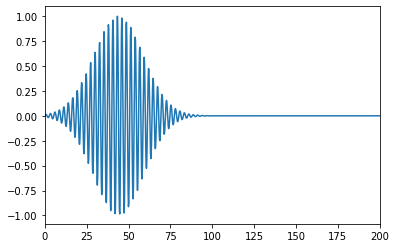

In [12]:
plt.plot(time,pulse)
plt.xlim(0,200)

In [15]:
pulse_freq,pulse_ft = G.evalPulseFourierTransform(time,pulse)

time unit: fs - energy unit: eV
energy resolution of the FT: 0.004134841388768031 eV
maximum energy: 10.341238313308846 eV
FWHM of the FT of the pulse: 0.09923619333043288 eV


In [16]:
alpha_exp= 'Experiment/alpha.dat'
data = np.loadtxt(alpha_exp,delimiter=',').T
energy_alpha,alpha_exp = data

abs_file = 'EQ_ABS_IP/12x12x3/ip_abs-bnds_42-62/o-ip_abs-bnds_42-62.eps_q1_ip'
data = P.YamboOutputParser.from_file(abs_file)['eps_q1_ip']
energy = data['energy'][80:] # starts from 1 eV
eps_im = data['eps_imag'][80:]
alpha = eps_im*energy
alpha_norm = alpha/max(alpha)

Parse file EQ_ABS_IP/12x12x3/ip_abs-bnds_42-62/o-ip_abs-bnds_42-62.eps_q1_ip


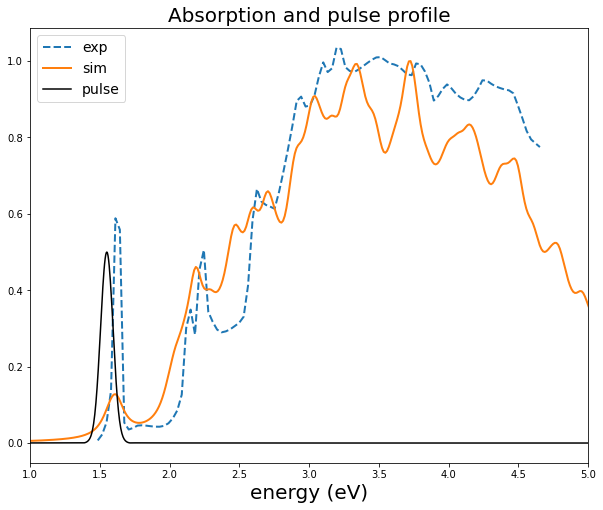

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(energy_alpha,alpha_exp,label='exp',linestyle='--',linewidth=2)
ax.plot(energy,alpha_norm,label='sim',linewidth=2) 
ax.plot(pulse_freq,pulse_ft/max(2*pulse_ft),c='black',label='pulse')
ax.set_xlim(1,5)
#ax.set_ylabel(r'$\alpha$',size=20)
ax.set_xlabel('energy (eV)',size=20)
ax.set_title('Absorption and pulse profile',size=20)
ax.legend(fontsize=14)

Now we peform a RT simulation

In [7]:
n_tasks = ntasks_per_node*nodes

field_int = [1e7,2e7,5e7,1e8] # intensity of the pulses in kW/cm^2
fwhm = 35 # fs 
energy = 2.05 #1.55 # eV
time_step = 10 # as
sim_time = 150 # fs
bands = [41,62]
XfnQP_E = {'9x9x1' :  [0.25,1.,1.], '12x12x3' : [0.18,1.,1.], '16x16x4' : [0.0,1,1.2]}
eta = 0.07 # eV
io_time = [10.0,10.0,1.]  # I/O (CARRIERs - GF - OUTPUT) in fs 
io_cache_time = [1.,10.] # Time between two consecutive (caching - I/O) of OBSERVABLES in fs

study = D.Dataset(num_tasks=1,verbose=True,skip=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput('yambo_rt -n p -v ip -V rt',folder=run_dir)
inp.set_rt_bands(bands=bands,scissor=XfnQP_E[k][0],damping_valence=eta,damping_conduction=eta)
inp.set_rt_simulationTimes(sim_time=sim_time,io_time=io_time,io_cache_time=io_cache_time,time_step=time_step)
inp.set_rt_cpu(ntasks)
inp['variables']['DBsIOoff']='obs GF CARRIERs'  # do not write these ndbs on disk
for f in field_int:
    inp.set_rt_field(int=f,fwhm=fwhm,polarization='linear',freq=energy)
    idd = 'ip_field-int_%s-energy_%s'%(f,energy)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir)

Initialize a Dataset with 1 parallel tasks


In [8]:
#study.runs[1]

In [10]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0], [1], [2], [3]] 

Run the task [0] 
Skip the run of ip_field-int_10000000.0-energy_2.05
Task [0] ended 
 
Run the task [1] 
Skip the run of ip_field-int_20000000.0-energy_2.05
Task [1] ended 
 
Run the task [2] 
Skip the run of ip_field-int_50000000.0-energy_2.05
Task [2] ended 
 
Run the task [3] 
Skip the run of ip_field-int_100000000.0-energy_2.05
Task [3] ended 
 


In [11]:
bohr_cm = U.Constants.Bohr_radius*1e2
vol_direct = results[0].dft.eval_lattice_volume()*bohr_cm**3

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

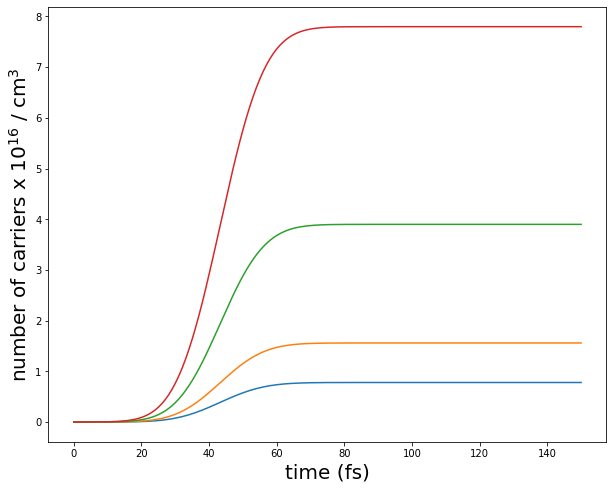

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

for r in results.values():
    data = r.data['carriers']
    t = data['time']
    dne = data['dne']
    ax.plot(t,dne/vol_direct/1e16)
ax.set_xlabel('time (fs)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)

Text(0, 0.5, 'number of carriers x $10^{16}$ / cm$^3$')

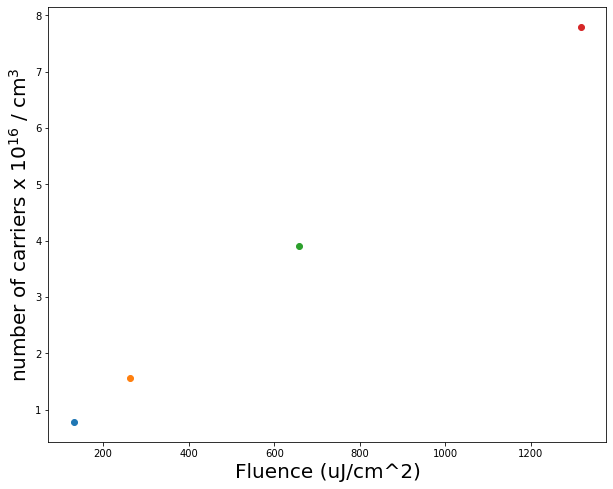

In [13]:
fluence,carriers = [],[]

for r in results.values():
    data = r.data['external_field']
    fluence.append(data['Fluence'][-1]/1e3)             
    data = r.data['carriers']
    carriers.append(data['dne'][-1]/vol_direct/1e16)

fig, ax = plt.subplots(figsize=(10, 8))

for f,c in zip(fluence,carriers):
    ax.scatter(f,c)
ax.set_xlabel('Fluence (uJ/cm^2)',size=20)
ax.set_ylabel('number of carriers x $10^{16}$ / cm$^3$',size=20)